In [1]:
import chess
import chess.engine
import random
import numpy
from stockfish import Stockfish
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


def random_board(maxD=200):
    board = chess.Board()
    depth = random.randrange(0, maxD)
    
    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break
    return board

def Da_fish(board, depth):
    # stockfish = Stockfish('stockfish/stockfish/stockfish-windows-x86-64-avx2.exe')
    # stockfish.set_depth(20)
    # stockfish.set_skill_level(20)
    # stockfish.set_fen_position(board.fen())
    # return stockfish.get_evaluation()
    with chess.engine.SimpleEngine.popen_uci('stockfish/stockfish/stockfish-windows-x86-64-avx2.exe') as sf:
        result = sf.analyse(board, chess.engine.Limit(depth=depth))
        score = result['score'].white().score()
        return score



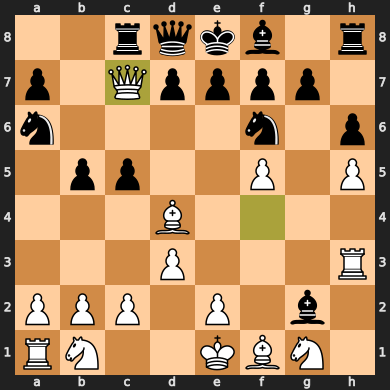

In [34]:
board = random_board()
board


In [35]:
Da_fish(board, 24)

-646

In [2]:
squares_index = {
    'a':0,
    'b':1,
    'c':2,
    'd':3,
    'e':4,
    'f':5,
    'g':6,
    'h':7,
}

def square_to_index(square):
    letter =  chess.square_name(square)
    return 8 - int(letter[1]), squares_index[letter[0]]

def split_dims(board):
    board3d = numpy.zeros((14,8,8), dtype=numpy.int8)
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece - 1][7 -idx[0]][idx[1]] = 1
        for square in board.pieces(piece, chess.BLACK):
            idx = numpy. unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1
    # add attacks and valid moves too
    # so the network knows what is being attacked
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j= square_to_index(move.to_square)
        board3d[12][i][j] = 1
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j= square_to_index(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux
    
    return board3d

In [37]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, conv_size, conv_depth):
        super(Net, self).__init__()
        # Adjust the in_channels of the first convolutional layer to match the input data
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=14 if i == 0 else conv_size,
                                              out_channels=conv_size,
                                              kernel_size=3,
                                              padding='same')
                                    for i in range(conv_depth)])
        self.fc1 = nn.Linear(conv_size * 8 * 8, 64)  # Adjust the size accordingly if the input volume changes
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Apply the convolutional layers
        for conv in self.convs:
            x = F.relu(conv(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Adjust `conv_size` and `conv_depth` as needed
conv_size = 64
conv_depth = 5
net = Net(conv_size, conv_depth)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, 
                               kernel_size=3, padding=1) # padding='same'
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, 
                               kernel_size=3, padding=1) # padding='same'
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_channels, conv_size, conv_depth):
        super(ResNet, self).__init__()
        self.initial_conv = nn.Conv2d(input_channels, conv_size, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(
            *(ResidualBlock(conv_size) for _ in range(conv_depth))
        )
        # Assuming the input size is (14, 8, 8), you need to calculate the flattened size
        # after the convolutions and before the first linear layer. This will depend on
        # the number of convolutions and their stride and padding. If it's not (14, 8, 8) after
        # the initial convolution, you will need to adjust the size here accordingly.
        #self.fc1 = nn.Linear(conv_size * 14 * 8 * 8, 64)  # Adjusted flattened size
        self.fc1 = nn.Linear(2048, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        x = self.blocks(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Usage
input_channels = 14  # Update this to the number of input channels in your data
conv_size = 32
conv_depth = 4
net = ResNet(input_channels, conv_size, conv_depth)

In [ ]:
board = random_board()
print(board)
print(Da_fish(board))

In [ ]:
positions = []
evaluations = []

# Approximate size tracking (very rough estimate)
dataset_size_bytes = 0
target_size_bytes = 10 * 1024 *1024  # 2GB

while dataset_size_bytes < target_size_bytes:
    board = random_board()
    board3d = split_dims(board)
    evaluation = Da_fish(board, depth=20)  # Example depth

    if evaluation:
        positions.append(board3d)
        evaluations.append(evaluation)

    # Update dataset size (this needs to be adjusted based on actual size calculations)
    dataset_size_bytes += board3d.nbytes + numpy.dtype(numpy.int32).itemsize

    if len(positions) % 100 == 0:  # Adjust based on memory capacity
        print(f"Generated {len(positions)} positions, current dataset size approximately {dataset_size_bytes/1024**2:.2f} MB")

# Convert lists to numpy arrays
print(evaluations)
positions_array = numpy.array(positions, dtype=numpy.int8)
evaluations_array = numpy.array(evaluations, dtype=numpy.int32)

# Save to NPZ
numpy.savez_compressed('dataeval/chess_data.npz', positions=positions_array, evaluations=evaluations_array)

In [8]:
import numpy as np
import chess
import os

def save_data_incrementally(board3d, evaluation, index):
    np.savez_compressed(f'chess_data_partial_{index}.npz', position=board3d, evaluation=evaluation)


def merge_data_files():
    position_list = []
    evaluation_list = []
    
    # Assuming your partial files are in the current directory
    for file_name in os.listdir('.'):
        if file_name.startswith('chess_data_partial_') and file_name.endswith('.npz'):
            data = np.load(file_name)
            position_list.append(data['position'])
            evaluation_list.append(data['evaluation'])
            os.remove(file_name)  # Optional: remove the partial file after merging

    # Convert lists to numpy arrays
    positions_array = np.array(position_list)
    evaluations_array = np.array(evaluation_list)

    # Save the merged dataset
    np.savez_compressed('chess_dataset_full.npz', positions=positions_array, evaluations=evaluations_array)

    print("Merged dataset saved as 'chess_dataset_full.npz'.")





In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [ ]:
#broski has 1,500,000 positions

In [5]:
import numpy as np
def get_dataset():
    container = np.load('chess_data.npz')
    b, v = container['positions'], container['evaluations']
    v = np.asarray(v/abs(v).max()/2+0.5)
    return b, v

x_train, y_train = get_dataset()

x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X, Y = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X[10], Y[10]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.,

In [14]:
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

# Assuming net is an instance of the Net class we've defined earlier

# Define the optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=5e-4)
criterion = MSELoss()

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(X, dtype=torch.float32)
y_train_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048)

# Early stopping and ReduceLROnPlateau equivalents in PyTorch
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
early_stopping_patience = 80
min_delta = 0.0001
epochs_no_improve = 0
min_val_loss = float('inf')

# Training loop
for epoch in range(1000):
    # Training phase
    net.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    scheduler.step(val_loss)
    
    # Check early stopping
    if val_loss + min_delta < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
    if epoch % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch}, Validation loss: {val_loss:.4f}')
    if epochs_no_improve == early_stopping_patience:
        print('Early stopping!')
        break

# Save the model
torch.save(net.state_dict(), 'model.pth')

C:\Users\samue\AppData\Local\Temp\ipykernel_21704\2000226436.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(X, dtype=torch.float32)
C:\Users\samue\AppData\Local\Temp\ipykernel_21704\2000226436.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(Y, dtype=torch.float32)
c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packag

Epoch 0, Validation loss: 0.0281
Epoch 10, Validation loss: 0.0281
Epoch 20, Validation loss: 0.0281
Epoch 30, Validation loss: 0.0281
Epoch 40, Validation loss: 0.0281
Epoch 50, Validation loss: 0.0281
Epoch 60, Validation loss: 0.0281
Epoch 70, Validation loss: 0.0281


KeyboardInterrupt: 

In [17]:

import torch.optim as optim
import numpy
import torch

# Assuming your code and the Net class definition are here

# # Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to tensors
x_train_tensor = X.to(device)
y_train_tensor = Y.to(device)

# Create a dataset and data loader
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 100  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

print('Finished Training')



Epoch 1, Loss: 0.6866934660577426
Epoch 2, Loss: 0.6739399724633154
Epoch 3, Loss: 0.663992138239589
Epoch 4, Loss: 0.6613592074735322
Epoch 5, Loss: 0.6594173951740683
Epoch 6, Loss: 0.6574208122970414
Epoch 7, Loss: 0.6565565932406127
Epoch 8, Loss: 0.6547844988586259
Epoch 9, Loss: 0.6547136606961271
Epoch 10, Loss: 0.6515915889809601
Epoch 11, Loss: 0.6490384318532735
Epoch 12, Loss: 0.6476904301747789
Epoch 13, Loss: 0.6451699181194723
Epoch 14, Loss: 0.6434806424335842
Epoch 15, Loss: 0.643292458388057
Epoch 16, Loss: 0.6419494143367683
Epoch 17, Loss: 0.6402270141309195
Epoch 18, Loss: 0.6400348017685604
Epoch 19, Loss: 0.6399588545743566
Epoch 20, Loss: 0.6392299541591728
Epoch 21, Loss: 0.638944759421105
Epoch 22, Loss: 0.6381540115732346
Epoch 23, Loss: 0.6380686364034667
Epoch 24, Loss: 0.6379548781109552
Epoch 25, Loss: 0.6379082037584625
Epoch 26, Loss: 0.6380983504065632
Epoch 27, Loss: 0.6379114293704068
Epoch 28, Loss: 0.6375934394606708
Epoch 29, Loss: 0.63749143285472

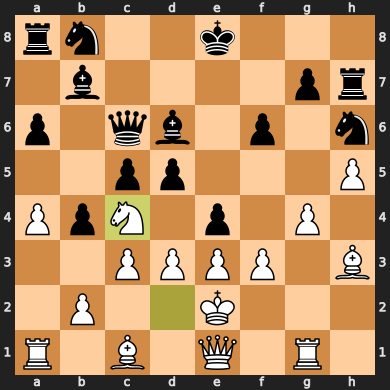

In [67]:
board = random_board()
board

In [68]:
container = np.load('chess_data.npz')
b, v = container['positions'], container['evaluations']


print(net(torch.tensor(numpy.expand_dims(split_dims(board), 0), dtype=torch.float32).to(device)))
print(np.asarray(Da_fish(board, 10)/abs(v).max()/2+0.5))

tensor([[0.4120]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.33171324422843257
